In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset     = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# 재현성을 위해 seed 고정!
train_size = int(len(train_val_dataset) * 0.9)
val_size   = len(train_val_dataset) - train_size
train_set, val_set = random_split(
    train_val_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # seed 고정
)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:06<00:00, 27.4MB/s]


## Plane Network (CNN)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),   # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),               # 16x16

            nn.Conv2d(64, 128, 3, padding=1), # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),               # 8x8

            nn.Conv2d(128, 256, 3, padding=1),# 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)                # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
num_epochs    = 82
learning_rate = 0.1  # 초기 lr
criterion     = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_correct, total = 0, 0, 0
    for inputs, labels in tqdm(loader, desc='Train', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, running_correct/total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Valid', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, running_correct/total

> 논문에서는 164 -> 82 에포크를 지나면 학습률을 *0.1 해주어 초기 0.1에서 0.01로 변형하였다. 에포크가 너무 과한 것 같아서 절반인 82 -> 41로 에포크 수를 줄이고 감마 0.1 해주는 것을 동일하게 적용했다.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cnn = CNN(num_classes=10).to(device)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# 논문처럼 MultiStepLR 적용 (epoch 41에서 lr 1/10로 감소)
scheduler_cnn = optim.lr_scheduler.MultiStepLR(optimizer_cnn, milestones=[41], gamma=0.1)

train_losses_cnn = []
valid_losses_cnn = []
train_accs_cnn   = []
valid_accs_cnn   = []
train_errs_cnn   = []
valid_errs_cnn   = []

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model_cnn, train_loader, optimizer_cnn, criterion, device)
    val_loss,   val_acc   = validate(model_cnn, val_loader, criterion, device)

    train_losses_cnn.append(train_loss)
    valid_losses_cnn.append(val_loss)

    train_accs_cnn.append(train_acc)
    valid_accs_cnn.append(val_acc)

    train_errs_cnn.append(1.0 - train_acc)
    valid_errs_cnn.append(1.0 - val_acc)

    scheduler_cnn.step()

    print(f"Epoch [{epoch}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}% ")

Epoch [1/82] | Train Loss: 1.3998 Train Acc: 49.63% | Val Loss: 1.2099 Val Acc: 57.10% 


Epoch [2/82] | Train Loss: 1.0013 Train Acc: 64.61% | Val Loss: 1.0564 Val Acc: 63.22% 


Epoch [3/82] | Train Loss: 0.8582 Train Acc: 69.64% | Val Loss: 0.9424 Val Acc: 66.16% 


Epoch [4/82] | Train Loss: 0.7832 Train Acc: 72.54% | Val Loss: 1.0241 Val Acc: 64.98% 


Epoch [5/82] | Train Loss: 0.7278 Train Acc: 74.51% | Val Loss: 0.8592 Val Acc: 69.26% 


Epoch [6/82] | Train Loss: 0.6893 Train Acc: 75.92% | Val Loss: 0.8124 Val Acc: 72.44% 


Epoch [7/82] | Train Loss: 0.6625 Train Acc: 76.88% | Val Loss: 0.7457 Val Acc: 74.24% 


Epoch [8/82] | Train Loss: 0.6396 Train Acc: 77.54% | Val Loss: 0.7616 Val Acc: 73.60% 


Epoch [9/82] | Train Loss: 0.6230 Train Acc: 78.36% | Val Loss: 0.7122 Val Acc: 74.88% 


Epoch [10/82] | Train Loss: 0.6087 Train Acc: 78.81% | Val Loss: 0.7087 Val Acc: 74.74% 


Epoch [11/82] | Train Loss: 0.5924 Train Acc: 79.44% | Val Loss: 0.7429 Val Acc: 73.98% 


Epoch [12/82] | Train Loss: 0.5829 Train Acc: 79.67% | Val Loss: 0.6750 Val Acc: 76.46% 


Epoch [13/82] | Train Loss: 0.5729 Train Acc: 80.07% | Val Loss: 0.6605 Val Acc: 76.44% 


Epoch [14/82] | Train Loss: 0.5661 Train Acc: 80.50% | Val Loss: 0.6717 Val Acc: 76.34% 


Epoch [15/82] | Train Loss: 0.5510 Train Acc: 80.79% | Val Loss: 0.6549 Val Acc: 76.98% 


Epoch [16/82] | Train Loss: 0.5550 Train Acc: 80.61% | Val Loss: 0.7521 Val Acc: 74.30% 


Epoch [17/82] | Train Loss: 0.5463 Train Acc: 81.08% | Val Loss: 0.6386 Val Acc: 77.30% 


Epoch [18/82] | Train Loss: 0.5370 Train Acc: 81.12% | Val Loss: 0.7796 Val Acc: 73.46% 


Epoch [19/82] | Train Loss: 0.5389 Train Acc: 81.42% | Val Loss: 0.6850 Val Acc: 75.72% 


Epoch [20/82] | Train Loss: 0.5368 Train Acc: 81.42% | Val Loss: 0.7620 Val Acc: 73.54% 


Epoch [21/82] | Train Loss: 0.5265 Train Acc: 81.82% | Val Loss: 0.6918 Val Acc: 75.58% 


Epoch [22/82] | Train Loss: 0.5270 Train Acc: 81.76% | Val Loss: 0.7170 Val Acc: 74.96% 


Epoch [23/82] | Train Loss: 0.5220 Train Acc: 81.87% | Val Loss: 0.6592 Val Acc: 77.18% 


Epoch [24/82] | Train Loss: 0.5233 Train Acc: 81.93% | Val Loss: 0.7427 Val Acc: 75.84% 


Epoch [25/82] | Train Loss: 0.5168 Train Acc: 82.10% | Val Loss: 0.6129 Val Acc: 78.54% 


Epoch [26/82] | Train Loss: 0.5132 Train Acc: 82.26% | Val Loss: 0.7273 Val Acc: 74.84% 


Epoch [27/82] | Train Loss: 0.5150 Train Acc: 82.29% | Val Loss: 0.7536 Val Acc: 74.08% 


Epoch [28/82] | Train Loss: 0.5073 Train Acc: 82.52% | Val Loss: 0.7443 Val Acc: 74.56% 


Epoch [29/82] | Train Loss: 0.5124 Train Acc: 82.27% | Val Loss: 0.7907 Val Acc: 73.86% 


Epoch [30/82] | Train Loss: 0.5082 Train Acc: 82.51% | Val Loss: 0.6075 Val Acc: 77.94% 


Epoch [31/82] | Train Loss: 0.5118 Train Acc: 82.32% | Val Loss: 0.6559 Val Acc: 77.52% 


Epoch [32/82] | Train Loss: 0.5094 Train Acc: 82.36% | Val Loss: 0.6324 Val Acc: 78.02% 


Epoch [33/82] | Train Loss: 0.5039 Train Acc: 82.55% | Val Loss: 0.7075 Val Acc: 76.26% 


Epoch [34/82] | Train Loss: 0.4974 Train Acc: 82.79% | Val Loss: 0.6410 Val Acc: 77.96% 


Epoch [35/82] | Train Loss: 0.5041 Train Acc: 82.53% | Val Loss: 0.6811 Val Acc: 76.72% 


Epoch [36/82] | Train Loss: 0.5004 Train Acc: 82.80% | Val Loss: 0.6550 Val Acc: 77.10% 


Epoch [37/82] | Train Loss: 0.4949 Train Acc: 82.79% | Val Loss: 0.7101 Val Acc: 76.20% 


Epoch [38/82] | Train Loss: 0.5001 Train Acc: 82.81% | Val Loss: 0.7498 Val Acc: 74.08% 


Epoch [39/82] | Train Loss: 0.4948 Train Acc: 82.84% | Val Loss: 0.6274 Val Acc: 78.36% 


Epoch [40/82] | Train Loss: 0.5057 Train Acc: 82.42% | Val Loss: 0.6232 Val Acc: 78.30% 


Epoch [41/82] | Train Loss: 0.4956 Train Acc: 82.85% | Val Loss: 0.6255 Val Acc: 78.22% 


Epoch [42/82] | Train Loss: 0.3456 Train Acc: 88.31% | Val Loss: 0.3922 Val Acc: 86.24% 


Epoch [43/82] | Train Loss: 0.2949 Train Acc: 90.12% | Val Loss: 0.3742 Val Acc: 86.68% 


Epoch [44/82] | Train Loss: 0.2746 Train Acc: 90.78% | Val Loss: 0.3815 Val Acc: 87.04% 


Epoch [45/82] | Train Loss: 0.2573 Train Acc: 91.32% | Val Loss: 0.3686 Val Acc: 86.82% 


Epoch [46/82] | Train Loss: 0.2432 Train Acc: 91.77% | Val Loss: 0.3627 Val Acc: 87.24% 


Epoch [47/82] | Train Loss: 0.2356 Train Acc: 92.08% | Val Loss: 0.3654 Val Acc: 87.22% 


Epoch [48/82] | Train Loss: 0.2246 Train Acc: 92.54% | Val Loss: 0.3539 Val Acc: 87.60% 


Epoch [49/82] | Train Loss: 0.2165 Train Acc: 92.69% | Val Loss: 0.3608 Val Acc: 87.50% 


Epoch [50/82] | Train Loss: 0.2121 Train Acc: 92.92% | Val Loss: 0.3594 Val Acc: 87.10% 


Epoch [51/82] | Train Loss: 0.2025 Train Acc: 93.07% | Val Loss: 0.3770 Val Acc: 87.02% 


Epoch [52/82] | Train Loss: 0.1980 Train Acc: 93.47% | Val Loss: 0.3542 Val Acc: 88.02% 


Epoch [53/82] | Train Loss: 0.1918 Train Acc: 93.50% | Val Loss: 0.3671 Val Acc: 87.44% 


Epoch [54/82] | Train Loss: 0.1888 Train Acc: 93.59% | Val Loss: 0.3467 Val Acc: 87.86% 


Epoch [55/82] | Train Loss: 0.1832 Train Acc: 93.78% | Val Loss: 0.3617 Val Acc: 87.50% 


Epoch [56/82] | Train Loss: 0.1772 Train Acc: 94.16% | Val Loss: 0.3422 Val Acc: 88.46% 


Epoch [57/82] | Train Loss: 0.1744 Train Acc: 94.24% | Val Loss: 0.3610 Val Acc: 87.52% 


Epoch [58/82] | Train Loss: 0.1681 Train Acc: 94.39% | Val Loss: 0.3575 Val Acc: 87.76% 


Epoch [59/82] | Train Loss: 0.1671 Train Acc: 94.38% | Val Loss: 0.3514 Val Acc: 87.96% 


Epoch [60/82] | Train Loss: 0.1622 Train Acc: 94.59% | Val Loss: 0.3822 Val Acc: 86.72% 


Epoch [61/82] | Train Loss: 0.1588 Train Acc: 94.64% | Val Loss: 0.3624 Val Acc: 87.72% 


Epoch [62/82] | Train Loss: 0.1600 Train Acc: 94.66% | Val Loss: 0.3803 Val Acc: 87.52% 


Epoch [63/82] | Train Loss: 0.1553 Train Acc: 94.80% | Val Loss: 0.3782 Val Acc: 87.20% 


Epoch [64/82] | Train Loss: 0.1602 Train Acc: 94.65% | Val Loss: 0.3688 Val Acc: 87.18% 


Epoch [65/82] | Train Loss: 0.1525 Train Acc: 94.90% | Val Loss: 0.3631 Val Acc: 87.42% 


Epoch [66/82] | Train Loss: 0.1504 Train Acc: 94.98% | Val Loss: 0.3987 Val Acc: 86.90% 


Epoch [67/82] | Train Loss: 0.1511 Train Acc: 95.02% | Val Loss: 0.3867 Val Acc: 87.20% 


Epoch [68/82] | Train Loss: 0.1493 Train Acc: 95.02% | Val Loss: 0.3823 Val Acc: 87.36% 


Epoch [69/82] | Train Loss: 0.1452 Train Acc: 95.16% | Val Loss: 0.3597 Val Acc: 87.62% 


Epoch [70/82] | Train Loss: 0.1465 Train Acc: 95.02% | Val Loss: 0.3999 Val Acc: 87.22% 


Epoch [71/82] | Train Loss: 0.1434 Train Acc: 95.11% | Val Loss: 0.3944 Val Acc: 87.02% 


Epoch [72/82] | Train Loss: 0.1465 Train Acc: 95.20% | Val Loss: 0.3851 Val Acc: 87.36% 


Epoch [73/82] | Train Loss: 0.1391 Train Acc: 95.37% | Val Loss: 0.3843 Val Acc: 87.54% 


Epoch [74/82] | Train Loss: 0.1407 Train Acc: 95.22% | Val Loss: 0.3746 Val Acc: 87.58% 


Epoch [75/82] | Train Loss: 0.1465 Train Acc: 95.01% | Val Loss: 0.4165 Val Acc: 86.58% 


Epoch [76/82] | Train Loss: 0.1399 Train Acc: 95.38% | Val Loss: 0.4016 Val Acc: 86.72% 


Epoch [77/82] | Train Loss: 0.1468 Train Acc: 95.00% | Val Loss: 0.4148 Val Acc: 85.64% 


Epoch [78/82] | Train Loss: 0.1387 Train Acc: 95.41% | Val Loss: 0.4092 Val Acc: 86.62% 


Epoch [79/82] | Train Loss: 0.1445 Train Acc: 95.22% | Val Loss: 0.3722 Val Acc: 87.84% 


Epoch [80/82] | Train Loss: 0.1431 Train Acc: 95.15% | Val Loss: 0.3806 Val Acc: 87.28% 


Epoch [81/82] | Train Loss: 0.1389 Train Acc: 95.25% | Val Loss: 0.3781 Val Acc: 87.38% 


Epoch [82/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3920 Val Acc: 87.08% 


## RestNet34

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    # ResNet-18/34에서는 1, ResNet-50 이상은 4 -> bottleneck 사용함

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 차원 맞추기
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64

        # 논문에서는 7x7, stride=2이지만 CIFAR-10은 3x3, stride=1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_res34 = resnet34(num_classes=10).to(device)
print(model_res34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [ ]:
train_losses_r34 = []
valid_losses_r34 = []
train_accs_r34   = []
valid_accs_r34   = []
train_errs_r34   = []
valid_errs_r34   = []

optimizer_res34 = optim.SGD(
    model_res34.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=1e-4
)

# 논문에서는 82epoch, 41에서 lr 1/10로 줄임 (논문 appendix Table 5)
scheduler_res34 = optim.lr_scheduler.MultiStepLR(
    optimizer_res34,
    milestones=[41],
    gamma=0.1
)

for epoch in range(1, num_epochs+1):
    print(f'\n=== Epoch {epoch}/{num_epochs} === '
          f'lr: {scheduler_res34.get_last_lr()[0]:.5f}')

    # Train / Valid
    tr_loss, tr_acc = train_one_epoch(
        model_res34, train_loader,
        optimizer_res34, criterion, device
    )
    val_loss, val_acc = validate(
        model_res34, val_loader,
        criterion, device
    )

    scheduler_res34.step()

    train_losses_r34.append(tr_loss)
    valid_losses_r34.append(val_loss)

    train_accs_r34.append(tr_acc)
    valid_accs_r34.append(val_acc)

    train_errs_r34.append(1.0 - tr_acc)
    valid_errs_r34.append(1.0 - val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc*100:.2f}%")



=== Epoch 1/82 === lr: 0.10000


Epoch [2/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 2.0969 Val Acc: 25.08%

=== Epoch 2/82 === lr: 0.10000


Epoch [3/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 1.6083 Val Acc: 40.80%

=== Epoch 3/82 === lr: 0.10000


Epoch [4/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 1.4618 Val Acc: 46.44%

=== Epoch 4/82 === lr: 0.10000


Epoch [5/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 1.2976 Val Acc: 53.34%

=== Epoch 5/82 === lr: 0.10000


Epoch [6/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 1.1991 Val Acc: 57.32%

=== Epoch 6/82 === lr: 0.10000


Epoch [7/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 1.0478 Val Acc: 61.56%

=== Epoch 7/82 === lr: 0.10000


Epoch [8/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.9089 Val Acc: 68.10%

=== Epoch 8/82 === lr: 0.10000


Epoch [9/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.8352 Val Acc: 70.30%

=== Epoch 9/82 === lr: 0.10000


Epoch [10/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.8672 Val Acc: 69.02%

=== Epoch 10/82 === lr: 0.10000


Epoch [11/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.7386 Val Acc: 74.62%

=== Epoch 11/82 === lr: 0.10000


Epoch [12/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.7318 Val Acc: 74.22%

=== Epoch 12/82 === lr: 0.10000


Epoch [13/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.7554 Val Acc: 76.86%

=== Epoch 13/82 === lr: 0.10000


Epoch [14/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.6176 Val Acc: 78.38%

=== Epoch 14/82 === lr: 0.10000


Epoch [15/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.5915 Val Acc: 79.22%

=== Epoch 15/82 === lr: 0.10000


Epoch [16/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.5928 Val Acc: 78.80%

=== Epoch 16/82 === lr: 0.10000


Epoch [17/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.5794 Val Acc: 80.90%

=== Epoch 17/82 === lr: 0.10000


Epoch [18/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.6426 Val Acc: 80.78%

=== Epoch 18/82 === lr: 0.10000


Epoch [19/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4619 Val Acc: 83.62%

=== Epoch 19/82 === lr: 0.10000


Epoch [20/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4954 Val Acc: 82.88%

=== Epoch 20/82 === lr: 0.10000


Epoch [21/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4283 Val Acc: 85.60%

=== Epoch 21/82 === lr: 0.10000


Epoch [22/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.5328 Val Acc: 83.70%

=== Epoch 22/82 === lr: 0.10000


Epoch [23/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4121 Val Acc: 86.20%

=== Epoch 23/82 === lr: 0.10000


Epoch [24/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4189 Val Acc: 86.60%

=== Epoch 24/82 === lr: 0.10000


Epoch [25/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4205 Val Acc: 86.00%

=== Epoch 25/82 === lr: 0.10000


Epoch [26/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4053 Val Acc: 86.34%

=== Epoch 26/82 === lr: 0.10000


Epoch [27/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4122 Val Acc: 86.10%

=== Epoch 27/82 === lr: 0.10000


Epoch [28/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4374 Val Acc: 85.72%

=== Epoch 28/82 === lr: 0.10000


Epoch [29/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3769 Val Acc: 87.10%

=== Epoch 29/82 === lr: 0.10000


Epoch [30/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3672 Val Acc: 87.24%

=== Epoch 30/82 === lr: 0.10000


Epoch [31/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4394 Val Acc: 85.72%

=== Epoch 31/82 === lr: 0.10000


Epoch [32/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4344 Val Acc: 86.14%

=== Epoch 32/82 === lr: 0.10000


Epoch [33/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3646 Val Acc: 87.80%

=== Epoch 33/82 === lr: 0.10000


Epoch [34/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4351 Val Acc: 86.62%

=== Epoch 34/82 === lr: 0.10000


Epoch [35/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3781 Val Acc: 87.42%

=== Epoch 35/82 === lr: 0.10000


Epoch [36/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3821 Val Acc: 87.94%

=== Epoch 36/82 === lr: 0.10000


Epoch [37/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4076 Val Acc: 87.34%

=== Epoch 37/82 === lr: 0.10000


Epoch [38/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.4385 Val Acc: 85.78%

=== Epoch 38/82 === lr: 0.10000


Epoch [39/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3817 Val Acc: 88.18%

=== Epoch 39/82 === lr: 0.10000


Epoch [40/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3971 Val Acc: 87.14%

=== Epoch 40/82 === lr: 0.10000


Epoch [41/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3811 Val Acc: 88.24%

=== Epoch 41/82 === lr: 0.10000


Epoch [42/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3852 Val Acc: 87.82%

=== Epoch 42/82 === lr: 0.01000


Epoch [43/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2572 Val Acc: 91.76%

=== Epoch 43/82 === lr: 0.01000


Epoch [44/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2669 Val Acc: 92.12%

=== Epoch 44/82 === lr: 0.01000


Epoch [45/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2582 Val Acc: 91.98%

=== Epoch 45/82 === lr: 0.01000


Epoch [46/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2643 Val Acc: 92.68%

=== Epoch 46/82 === lr: 0.01000


Epoch [47/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2745 Val Acc: 92.22%

=== Epoch 47/82 === lr: 0.01000


Epoch [48/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2706 Val Acc: 92.70%

=== Epoch 48/82 === lr: 0.01000


Epoch [49/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2746 Val Acc: 92.40%

=== Epoch 49/82 === lr: 0.01000


Epoch [50/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2815 Val Acc: 92.54%

=== Epoch 50/82 === lr: 0.01000


Epoch [51/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2874 Val Acc: 92.52%

=== Epoch 51/82 === lr: 0.01000


Epoch [52/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2898 Val Acc: 92.82%

=== Epoch 52/82 === lr: 0.01000


Epoch [53/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2834 Val Acc: 93.04%

=== Epoch 53/82 === lr: 0.01000


Epoch [54/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.2842 Val Acc: 92.54%

=== Epoch 54/82 === lr: 0.01000


Epoch [55/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3095 Val Acc: 92.46%

=== Epoch 55/82 === lr: 0.01000


Epoch [56/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3060 Val Acc: 92.72%

=== Epoch 56/82 === lr: 0.01000


Epoch [57/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3176 Val Acc: 92.60%

=== Epoch 57/82 === lr: 0.01000


Epoch [58/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3154 Val Acc: 92.74%

=== Epoch 58/82 === lr: 0.01000


Epoch [59/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3214 Val Acc: 92.80%

=== Epoch 59/82 === lr: 0.01000


Epoch [60/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3281 Val Acc: 92.68%

=== Epoch 60/82 === lr: 0.01000


Epoch [61/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3138 Val Acc: 92.74%

=== Epoch 61/82 === lr: 0.01000


Epoch [62/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3108 Val Acc: 92.64%

=== Epoch 62/82 === lr: 0.01000


Epoch [63/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3289 Val Acc: 92.72%

=== Epoch 63/82 === lr: 0.01000


Epoch [64/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3296 Val Acc: 92.54%

=== Epoch 64/82 === lr: 0.01000


Epoch [65/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3303 Val Acc: 92.66%

=== Epoch 65/82 === lr: 0.01000


Epoch [66/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3450 Val Acc: 92.28%

=== Epoch 66/82 === lr: 0.01000


Epoch [67/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3377 Val Acc: 92.42%

=== Epoch 67/82 === lr: 0.01000


Epoch [68/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3287 Val Acc: 92.80%

=== Epoch 68/82 === lr: 0.01000


Epoch [69/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3510 Val Acc: 92.48%

=== Epoch 69/82 === lr: 0.01000


Epoch [70/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3403 Val Acc: 92.72%

=== Epoch 70/82 === lr: 0.01000


Epoch [71/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3439 Val Acc: 92.40%

=== Epoch 71/82 === lr: 0.01000


Epoch [72/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3422 Val Acc: 92.66%

=== Epoch 72/82 === lr: 0.01000


Epoch [73/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3399 Val Acc: 92.62%

=== Epoch 73/82 === lr: 0.01000


Epoch [74/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3432 Val Acc: 92.90%

=== Epoch 74/82 === lr: 0.01000


Epoch [75/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3528 Val Acc: 92.32%

=== Epoch 75/82 === lr: 0.01000


Epoch [76/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3441 Val Acc: 92.56%

=== Epoch 76/82 === lr: 0.01000


Epoch [77/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3478 Val Acc: 92.36%

=== Epoch 77/82 === lr: 0.01000


Epoch [78/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3594 Val Acc: 92.66%

=== Epoch 78/82 === lr: 0.01000


Epoch [79/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3487 Val Acc: 92.46%

=== Epoch 79/82 === lr: 0.01000


Epoch [80/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3672 Val Acc: 92.64%

=== Epoch 80/82 === lr: 0.01000


Epoch [81/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3613 Val Acc: 92.38%

=== Epoch 81/82 === lr: 0.01000


Epoch [82/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3401 Val Acc: 92.90%

=== Epoch 82/82 === lr: 0.01000


Epoch [83/82] | Train Loss: 0.1389 Train Acc: 95.34% | Val Loss: 0.3486 Val Acc: 92.56%


## 학습 결과 그래프

### 손실 그래프

In [ ]:
epochs = range(1, num_epochs+1)

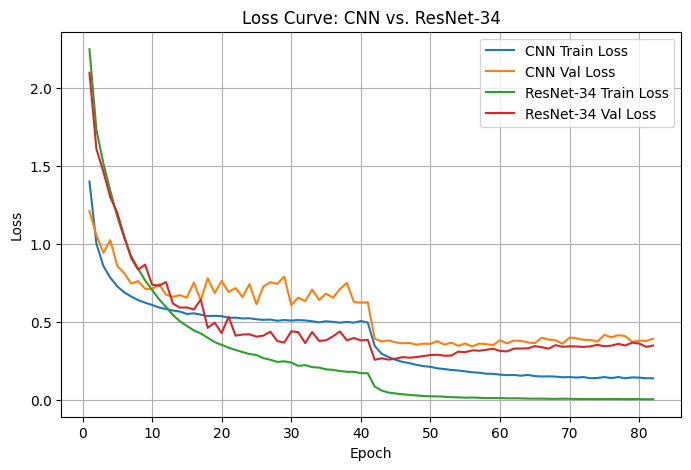

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses_cnn, label='CNN Train Loss')
plt.plot(epochs, valid_losses_cnn, label='CNN Val Loss')
plt.plot(epochs, train_losses_r34, label='ResNet-34 Train Loss')
plt.plot(epochs, valid_losses_r34, label='ResNet-34 Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve: CNN vs. ResNet-34')
plt.legend()
plt.grid(True)
plt.show()

#### 손실 그래프 분석

1. 그래프 해석
- 전체적인 그래프 경향을 봤을 때, 두 모델 모두 epoch가 지날수록 train/val loss가 크게 감소하면서 학습이 진행됨

- 초기 학습 (0~20 epoch)
    - 두 모델 다 학습손실, 검증 손실이 가파르게 감소함
- 학습 후반 (20 epoch ~)
    - ResNet-34의 학습손실/검증손실이 CNN보다 낮게 유지되고있으며, 특히 41 epoch 기점에서 loss가 뚜렷하게 하락했다. (이때부터, 학습률이 0.01) 하지만 결과적으로, ResNet-34가 더 낮은 손실로 0에 수렴한다.

2. 모델 설계 중심 분석
- Plain CNN
    - 구조적 특징 : Conv-BN-ReLU-Pool
    - 특징 : 깊이가 깊어질수록 기울기 소실 및 정보 손실이 나타남
    - 학습결과
        - train loss는 충분히 낮아지지만, val loss는 일정수준에서 머무르거나 노이즈가 많다.

- ResNet-34
    - 구조적 특징 : Resihual Block로 input을 블록 output에 더한다.
    - 특징 : 기울기가 shortchut connection으로 잘 전달되어 깊어져도 기울기 소실 및 학습 저하가 잘 나타나지 않음. 또한 깊은 층에도 불구하고 안정적이며 val loss가 낮다. 이는 잔차 연결로 필요할 땐 identity mapping만 남길 수 있기 때문이다.
    - 학습 결과
        - 같은 epoch, 같은 optimizer 조건에서도 val loss가 더 낮음


3. 논문 인용

> “When deeper networks are able to start converging, a degradation problem has been exposed: with the network depth increasing, accuracy gets saturated (which might be unsurprising) and then degrades rapidly. ...”
— He et al., 2015 (Section 4.2)

Plain CNN은 깊어질수록 validation loss가 plateau에 머물거나 더 나빠지는 “degradation problem”이 발생

> "Deep residual nets are easy to optimize, but can gain accuracy from considerably increased depth."
— He et al., 2015 (Abstract)

반면, ResNet은 Residual connection 덕분에 손실이 꾸준히 더 낮게 수렴하며,
일반화 성능이 확연히 뛰어남을 실험적으로 입증

### 정확도 그래프

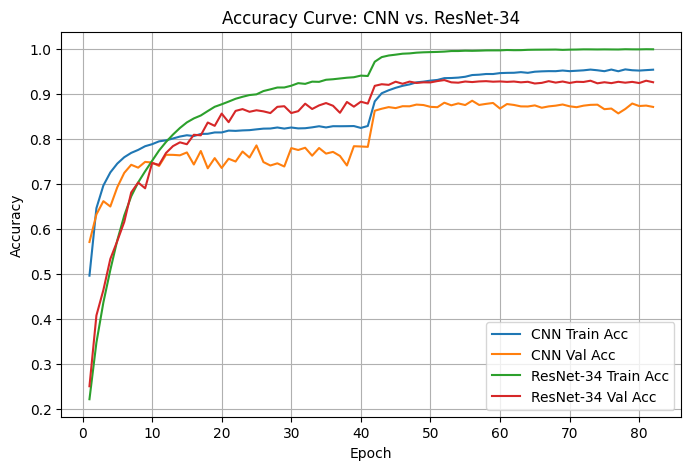

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs_cnn, label='CNN Train Acc')
plt.plot(epochs, valid_accs_cnn, label='CNN Val Acc')
plt.plot(epochs, train_accs_r34, label='ResNet-34 Train Acc')
plt.plot(epochs, valid_accs_r34, label='ResNet-34 Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve: CNN vs. ResNet-34')
plt.legend()
plt.grid(True)
plt.show()

#### 정확도 그래프 분석

1. 그래프 해석
- Train Accuracy
    - CNN과 ResNet-34 모두 학습 데이터에서는 95%이상의 높은 정확도 달성
    - 두 모델의 train acc 곡선이 거의 비슷하게 수렴

- Validation Accuracy
    - ResNet-34는 검증 데이터에서 최종 92.56%까지 상승
    - CNN은 87.08%로 멈췄으며 ResNet-34과 비교했을 때, 약 5%p 차이가 났다.
    - 학습률 감소(epoch 41 이후), 두 모델 모두 정확도가 상승하지만, ResNet-34의 상승폭과 최종 성능이 더 크다.

2. 모델 설계 중심 분석
- Plain CNN
    - 깊이가 제한적임
    - 기울기가 맨 앞까지 잘 전달되지않았을 것으로 예상됨
        - 학습데이터에서는 높은 성능을 보이는 반면에, 검증 데이터에서는 일반화에 한계를 보임. 또한 과적합 가능성도 예상됨

- ResNet-34
    - Residual Connection으로 인해 기울기가 shortcut을 통해 직접 전달되어 깊고 복잡해도 일반화할 수 있었을 것이라고 예상됨
    - 학습/검증 정확도 모두 cnn과 비교했을 때 좋았지만 특히, 검증 정확도에서 차이가 나타


3. 논문 인용

> "Deeper plain networks perform worse, but deep residual nets do not suffer from such degradation. Instead, residual networks enjoy consistently better accuracy as depth increases."
— He et al., 2015 (Table 6)

Plain CNN은 깊어질수록 validation accuracy에서 한계가 있고
ResNet은 validation accuracy가 더 높고, 더 안정적으로 수렴

> “Our extremely deep residual nets are easy to optimize, but can gain accuracy from considerably increased depth.”
— He et al., 2015 (Abstract)

잔차 연결 덕분에 모델이 깊어도 학습 및 일반화가 모두 가능한 설계임을 증명

### 오차 그래프

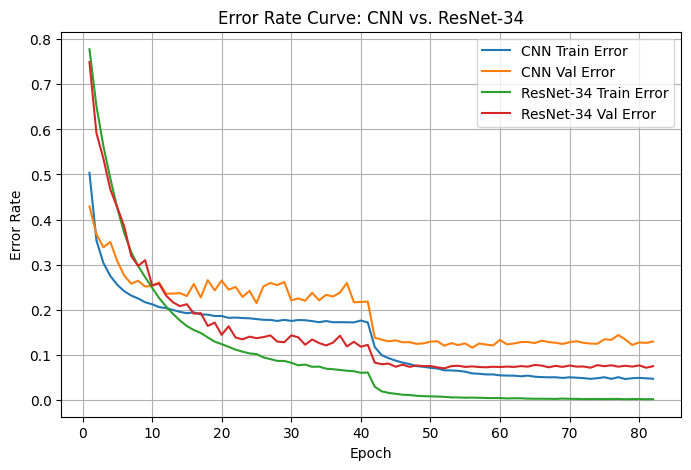

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_errs_cnn, label='CNN Train Error')
plt.plot(epochs, valid_errs_cnn, label='CNN Val Error')
plt.plot(epochs, train_errs_r34, label='ResNet-34 Train Error')
plt.plot(epochs, valid_errs_r34, label='ResNet-34 Val Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.title('Error Rate Curve: CNN vs. ResNet-34')
plt.legend()
plt.grid(True)
plt.show()

#### 오차 그래프 분석

1. 그래프 해석
- Train Accuracy
    - 두 모델 모두 0.05(5%) 이하까지 낮아짐 (train accuracy 95% 이상과 일치)

- Validation Accuracy
    - CNN: 약 0.13~0.14(최종 12.92%)에서 plateau
    - ResNet-34: 약 0.07~0.08(최종 7.44%)로 더 낮음

> 두 모델 모두 epoch 41 이후 error가 한 번 더 확 내려가지만
ResNet의 error가 더 낮고, 변동성도 적음(더 안정적)


2. 모델 설계 중심 분석
> 에러 곡선이 낮고, 안정적으로 수렴한다는 것은 일반화 성능이 높음을 의미한다. ResNet-34는 더 복잡한 패턴, 더 깊은 구조를 효과적으로 학습한 것과 반대로 Plain CNN은 구조적 한계로 error를 일정 이하로 줄이지 못함


3. 논문 인용

> "As shown in Fig. 4, plain networks encounter serious degradation when going deeper, whereas residual networks avoid such degradation and generalize better."
— He et al., 2015 (Figure 4 설명)

깊어질수록 plain 네트워크는 성능이 오히려 나빠지지만,
residual network는 깊어질수록 더 좋아진다.


#### cf. Plateau
> plateau란, 곡선이나 수치가 오르거나 내리지 않고 일정 구간 동안 거의 변화 없이 평평하게 유지되는 구간을 의미한다.
즉, 학습 곡선에서 손실(loss)이나 정확도(accuracy)가 더 이상 개선되지 않고 정체되는 상태이다.

## Test

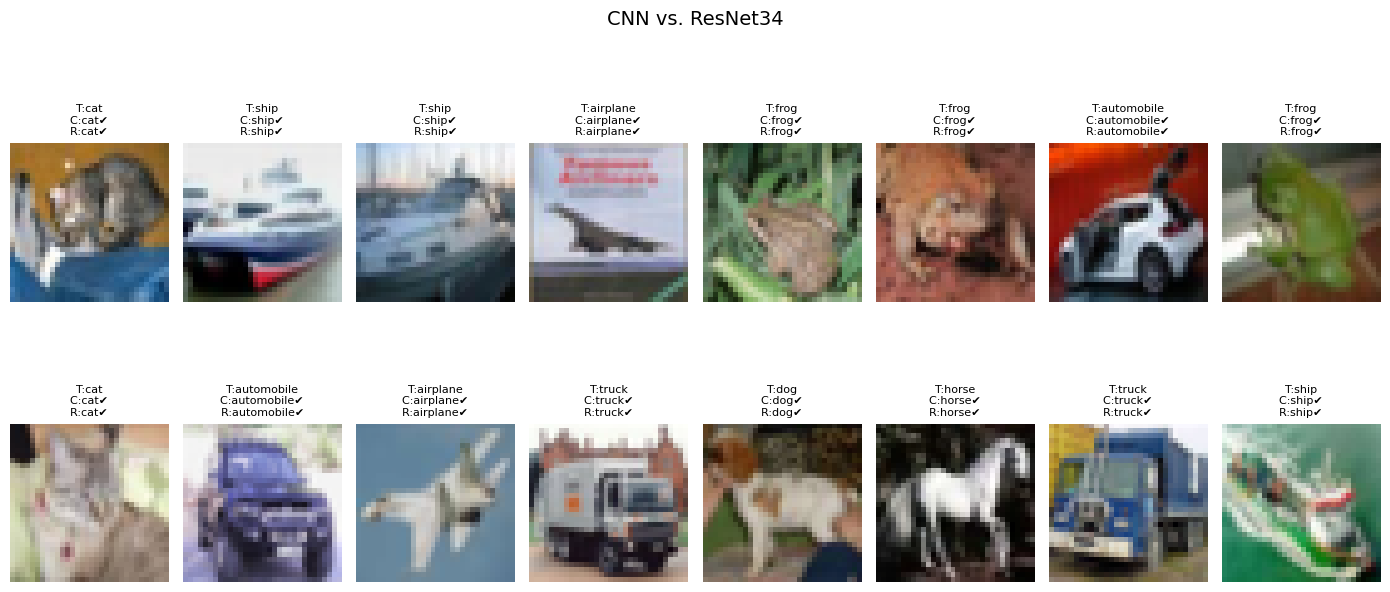

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

model_cnn.eval()
model_res34.eval()
with torch.no_grad():
    outputs_cnn = model_cnn(images)
    preds_cnn   = outputs_cnn.argmax(1)
    outputs_r34 = model_res34(images)
    preds_r34   = outputs_r34.argmax(1)

classes = test_loader.dataset.classes

def denormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).reshape(3,1,1).to(img.device)
    std  = torch.tensor([0.2023, 0.1994, 0.2010]).reshape(3,1,1).to(img.device)
    return img * std + mean

# 16장만 시각화
plt.figure(figsize=(14,7))
for i in range(16):
    plt.subplot(2,8,i+1)
    img = denormalize(images[i].cpu())
    img = img.permute(1,2,0).numpy()
    plt.imshow(np.clip(img, 0, 1))

    title  = f"T:{classes[labels[i]]}\n"
    title += f"C:{classes[preds_cnn[i]]}" + ("✔️" if preds_cnn[i]==labels[i] else "❌") + "\n"
    title += f"R:{classes[preds_r34[i]]}" + ("✔️" if preds_r34[i]==labels[i] else "❌")

    plt.title(title, fontsize=8)
    plt.axis('off')

plt.suptitle("CNN vs. ResNet34", fontsize=14)
plt.tight_layout()
plt.show()